In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 
from sklearn.preprocessing import LabelEncoder

In [293]:
#######################
## HELPER FUNCTIONS  ##
#######################

def is_fully_corrupted(string):
    if re.match(r'^[_]+$', string):
        return True
def is_partial_corrupted(string):
    if re.match(r'^[_]+[^_]+$', string): # front
        return True
    if re.match(r'^[^_]+[_]+$', string):  # end
        return True
    if re.match(r'^[^_]+[_]+[^_]+$', string): # middle
        return True
    else:
        return False
    
def has_number(string):
    return any(char.isdigit() for char in string)

# Multiplies a scalar and vectors
def scalar_times_vector(scalar, a, dim):
    B = np.zeros(dim)
    for i in range(dim):
        B[i] = scalar * a[i]
    return B

# Widrow Hoff learning rule 
def Widrow_Hoff(k, g, g_prime, f, dim):
    length_f = np.linalg.norm(f)
    difference_vector = np.subtract(g, g_prime)
    weighted_vector = k * difference_vector
    deltaA = np.outer(g, np.transpose(f))
    return deltaA, weighted_vector

In [310]:
#######################
## READ IN THE DATA  ##
#######################

data = []
with open("archival_data.txt", 'r') as f:
    lines = f.readlines()
    
lines = [line.split() for line in lines]

# Adjust for Color Names
for line in lines:
    if len(line) == 8:
        # Add a space between 4 and 5 if want later :
        line[4] = line[4] + line[5]
        line[5] = line[6]
        line[6] = line[7]
        del line[7]
    if re.match(r'.+[G][r][e][e][n]', line[4]):
        line[4] = "Green"

In [311]:
##########################
## CATEGORICAL FEATURES ##
##########################
# average values for filling in corrupted data
AVG_WARP_F = (6.7 + 6.8 + 6.5 + 6.4 + 6.5)/5
AVG_WARP_A = (6.7 + 6.8 + 6.5 + 6.8 + 6.7)/5
AVG_WARP_R = (7.3 + 7.4 + 7.3 + 7.2 + 7.4)/5
AVG_WARP_K = (6.9 + 7.0 + 7.3 + 7.1 + 7.1)/5
AVG_TRAN_F = (1050 + 1055 + 1045 +1065+ 1055)/5
AVG_TRAN_A = (1010.9 + 1033.2 + 1025.4 +1066.2 + 1015)/5
AVG_TRAN_R = (980.4+ 977.2+ 947.9 + 955.8+ 960.7)/5
AVG_TRAN_K = (1006.4 + 994.3+ 978.1+ 1005.4 + 1001.8)/5
AVG_AXIS_F = (1.9+ 2.0+ 2.1+ 2.6+ 1.7)/5
AVG_AXIS_A = (1.2+ 1.2+ 1.1+ 1.3+ 1.0)/5
AVG_AXIS_R = (1.6+ 1.8+ 1.9+ 2.1 + 2.3)/5
AVG_AXIS_K = (3.5+ 2.3+ 2.8+ 3.0+ 1.0)/5

train_df = pd.DataFrame(lines, columns=["name","planet","warp","transponder","surface","axis_ratio", "action"])

# g is the correct output, ie the ship's planet of origin
g = train_df["planet"]

# Convert pandas df columns to numpy arrays
G_set = g.to_numpy()
le = LabelEncoder()
le.fit(G_set)
G_set = le.transform(G_set)
print(G_set)

# Drop the Action and Planet of Origin columns
train_df = train_df.drop(['action', 'planet'], axis=1)

# CATEGORICAL FEATURE ENGINEERING
# One Hot Encode the Surface features (categorical) OR SHOULD I USE LABEL ENCODER??
surface_Dark = []
surface_Light = []
for color in train_df['surface']:
    if re.match(r'^[D][a][r][k].+$', color):
        surface_Dark.append(1)
    else:
        surface_Dark.append(0)
    if re.match(r'^[L][i][g][h][t].+$', color):
        surface_Light.append(1)
    else:
        surface_Light.append(0)
train_df['surface_Dark'] = np.where(surface_Dark, 1, 0)
train_df['surface_Light'] = np.where(surface_Light, 1, 0)
surface_features = pd.get_dummies(train_df['surface'], dummy_na= True, prefix='surface')
train_df = pd.concat([train_df, surface_features], axis=1).drop(['surface'],axis=1)
# Manually encode Name features:
# If name has digits, if first character is A or E, first two are consonants, contains double L
numeric_name = []
firstAE = []
first_consonants = []
double_l = []
last_k = []
for name in train_df['name']:
    # Check if name has digits [Antarean]
    if has_number(name):
        numeric_name.append(1)
    else:
        numeric_name.append(0)
    # Check if name starts with A or E [Antarean]
    if re.match(r'[AE].+', name):
        firstAE.append(1)
    else:
        firstAE.append(0)
    # Check if name starts with two consonants [Klingon]
    if re.match(r'^[^aeiouAEIOU]{2}.+', name):
        first_consonants.append(1)
    else:
        first_consonants.append(0)
    # Check if the name as double 'l' [Romulan]
    if re.match(r'.+[l]{2}.+', name):
        double_l.append(1)
    else:
        double_l.append(0)
    if re.match(r'.+[k]$', name):
        last_k.append(1)
    else:
        last_k.append(0)

# Add features
train_df['numeric_name'] = np.where(numeric_name, 1, 0)
train_df['firstAE'] = np.where(firstAE, 1, 0)
train_df['first_consonants'] = np.where(first_consonants, 1, 0)
train_df['double_l'] = np.where(double_l, 1, 0)
train_df['last_k'] = np.where(last_k, 1, 0)

[2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1]


In [312]:
#######################
## NUMERIC FEATURES ###
#######################

# Normalize the numeric values
# Xn = (X- Xmin)/(Xmaz - Xmin)

# Convert strings to floats in numeric columns
train_df['warp'] = [ float(w) for w in train_df['warp'] ]
train_df['transponder'] = [ float(t) for t in train_df['transponder'] ]
train_df['axis_ratio'] = [ float(a) for a in train_df['axis_ratio']]

min_warp = train_df['warp'].min()
max_warp = train_df['warp'].max()
train_df['norm_warp'] = (train_df['warp'] - min_warp) / (max_warp - min_warp)

min_t = train_df['transponder'].min()
max_t = train_df['transponder'].max()
train_df['norm_transpond'] = (train_df['transponder'] - min_t) / (max_t - min_t)

min_t = train_df['axis_ratio'].min()
max_t = train_df['axis_ratio'].max()
train_df['norm_axis'] = (train_df['axis_ratio'] - min_t) / (max_t - min_t)

# Finally, drop the name, warp, transponder, and axis_ratio columns
train_df = train_df.drop(['name', 'warp', 'transponder', 'axis_ratio'], axis=1)
print(train_df.shape)
train_df

(20, 21)


,surface_Dark,surface_Light,surface_Black,surface_DarkBlue,surface_DarkGray,surface_Green,surface_LightBlue,surface_LightGray,surface_Orange,surface_Pink,...,surface_Yellow,surface_nan,numeric_name,firstAE,first_consonants,double_l,last_k,norm_warp,norm_transpond,norm_axis
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.5,0.494505,1.00
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.6,0.392223,0.52
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0.9,0.255283,0.72
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0.7,0.486052,0.80
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0.7,0.455621,0.00
5,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.9,0.274725,0.24
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1.0,0.247675,0.32
7,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0.9,0.000000,0.36
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.8,0.066779,0.44
9,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1.0,0.108199,0.52


In [313]:
# train_X are the input features
# target_X are the targets

# Center and scale the f and g vectors
train_X = []
n = train_df.shape[0] # The number of ROWS
dim = train_df.shape[1] # The number of COLUMNS (features)


for key,value in train_df.iterrows():
    f = value.to_numpy()
    f = f.reshape((dim,1))
    # Center and Scale
    f = f - f.mean()
    f = f / np.linalg.norm(f)
    train_X.append(f)
    
# Klingon Romulan Antarean Federation
# G_set  # [2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1]

target = []
for i in range(20):
    if G_set[i] == 0:
        target.append(np.array([0,0,1,0]).reshape(4,1))
    elif G_set[i] == 1:
        target.append(np.array([0,0,0,1]).reshape((4,1)))
    elif G_set[i] == 2:
        target.append(np.array([1,0,0,0]).reshape(4,1))
    elif G_set[i] == 3:
        target.append(np.array([0,1,0,0]).reshape(4,1))

target_X = []
for g in target:
    MEAN = g.mean()
    LENGTH = g.mean()
    g = g - g.mean()
    g = g / np.linalg.norm(g)
    target_X.append(g)

In [314]:
ships = 20
n = 21
m = 4
A_i = [ np.outer(target_X[i], np.transpose(train_X[i])) for i in range(ships) ]

# Form the overall connectivity matrix A
# INITTIAL A MATRIX: 4x17
A = np.zeros((m,n))
for i in range(ships):
    A = np.add(A, A_i[i])

# Compute the output for each stored vector fi
G_prime = [ A.dot(train_X[i]) for i in range(ships) ]

learned = np.zeros(ships)
count = 0
converged = False
oscillate_input = False
errorThreshold = 0.0001;
Errors = []
k = 0.85

# Choose random pairs and store in array
randints = np.random.choice(20,20, replace=False)

while converged == False:
    mse = 0
    # Pick a random pair of f and g vectors
    r = randints[count]
    f = train_X[r]
    g = target_X[r]
    g_prime = A.dot(f)
    
    learned[count] = 1
    
    new_error = np.linalg.norm(error)
    deltaA, error = Widrow_Hoff(k, g, g_prime, f, ships)
    A = np.add(A, deltaA)
    error_length = np.linalg.norm(error)
    Errors.append(error_length)

    print("Current Error:", error_length)
    
    #if (abs(np.linalg.norm(error) - new_error) / np.linalg.norm(error) < errorThreshold) and (sum(learned) == n):
    if (abs(error_length) < errorThreshold):
        print("Error: ", abs(np.linalg.norm(error) - new_error) / np.linalg.norm(error))
        print("Error Threshold: ", errorThreshold)
        print("Number of trials: ", count)
        converged = True
        
    count = count + 1;
    k =  k - .05

Current Error: 1.2566639754838813
Current Error: 2.090419622511912
Current Error: 1.3549533611874107
Current Error: 2.248025492409231
Current Error: 1.4446306696734104
Current Error: 1.3903928692743297
Current Error: 0.9638954313653659
Current Error: 1.8668612083725038
Current Error: 2.089000095025079
Current Error: 1.029429055464269
Current Error: 1.3560189592003695
Current Error: 0.9789918740569763
Current Error: 0.8613147270537385
Current Error: 0.37987357778896746
Current Error: 0.5614982291863672
Current Error: 0.4249869956695492
Current Error: 0.05904582794246362
Current Error: 8.224071740891969e-16
Error:  71796343469225.12
Error Threshold:  0.0001
Number of trials:  17


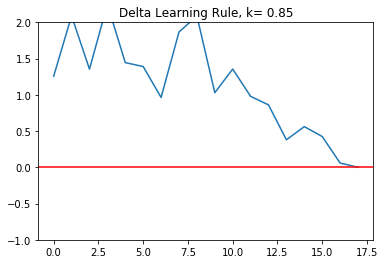

In [315]:
plt.plot(Errors,'-')
plt.ylim(-1,2)
plt.axhline(y=0,color="red")
plt.title("Delta Learning Rule, k= 0.85")
plt.show()

In [329]:
##################################
## CLASSIFICATIONS FOR TRAINING ##
##################################
# Now get target values again:
G_prime = [ A.dot(train_X[i]) for i in range(ships) ]
print("TRAINING SET PREDICTIONS")
for g in G_prime:
    target = g*LENGTH + MEAN
    # The max arg represents the classification of the planet of origin
    max_arg = np.argmax(target)
    if max_arg == 0:
        planet = "Klingon"
        msg = "HOSTILE"
        action = "Stay Alert"
    elif max_arg == 1:
        planet = "Romulan"
        msg = "POTENTIALLY HOSTILE"
        action = "Stay Alert"
    elif max_arg == 2:
        planet = "Antarean"
        msg = "PEACEFUL"
        action = "No action required, but be careful"
    elif max_arg == 3:
        planet = "Federation"
        msg = "PEACEFUL"
        action = "No action required"
    print(planet, "detected:" , msg, action)

TRAINING SET PREDICTIONS
Klingon detected: HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Antarean detected: PEACEFUL No action required, but be careful
Antarean detected: PEACEFUL No action required, but be careful
Antarean detected: PEACEFUL No action required, but be careful
Antarean detected: PEACEFUL No action required, but be careful
Antarean detected: PEACEFUL No action required, but be careful
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No a

In [319]:
#########################
## READ IN NOISY DATA  ##
#########################

data = []
with open("noisy_data.txt", 'r') as f:
    lines = f.readlines()
    
lines = [line.split() for line in lines]

# Adjust for Color Names
for line in lines:
    if len(line) == 8:
        # Add a space between 4 and 5 if want later :
        line[4] = line[4] + line[5]
        line[5] = line[6]
        line[6] = line[7]
        del line[7]

lines[11][4] = lines[11][4] + lines[11][5] + lines[11][6] + lines[11][7]
lines[11][5] = lines[11][8]
lines[11][6] = lines[11][9]
del lines[11][8]
del lines[11][8]
del lines[11][7]

test_df = pd.DataFrame(lines, columns=["name","planet","warp","transponder","surface","axis_ratio", "action"])

#########################
# FILL IN MISSING DATA ##
#########################

# FILL IN MISSING NUMERIC DATA WITH CATEGORICAL AVERGAES:

test_df = test_df.drop(["planet", "action"], axis=1)

surface_Dark = []
surface_Light = []
for color in test_df['surface']:
    if re.match(r'^[D][a][r][k].+$', color):
        surface_Dark.append(1)
    else:
        surface_Dark.append(0)
    if re.match(r'^[L][i][g][h][t].+$', color):
        surface_Light.append(1)
    else:
        surface_Light.append(0)
test_df['surface_Dark'] = np.where(surface_Dark, 1, 0)
test_df['surface_Light'] = np.where(surface_Light, 1, 0)
# # Fill in missing colors with NaN
test_df.iat[15,3] = float("nan")
test_df.iat[17,3] = float("nan")
test_df.iat[19,3] = float("nan")

surface_features = pd.get_dummies(test_df['surface'], dummy_na= True, prefix='surface')
test_df = pd.concat([test_df, surface_features], axis=1).drop(['surface'],axis=1)
test_df = test_df.drop(['surface_BlackorDkBlue', 'surface_DarkColor', 'surface_LightColor'], axis=1)

numeric_name = []
firstAE = []
first_consonants = []
double_l = []
last_k = []

# Fill in missing name values
for name in test_df["name"]:
    
    if is_fully_corrupted(name): # Completely corrupted
        numeric_name.append(0)
        firstAE.append(0)
        first_consonants.append(0)
        double_l.append(0)
        last_k.append(0)
        continue
    if has_number(name):
        numeric_name.append(1)
    else:
        numeric_name.append(0)
    # Check if name starts with A or E [Antarean]
    if re.match(r'[AE].+', name):
        firstAE.append(1)
    else:
        firstAE.append(0)
    # Check if name starts with two consonants [Klingon]
    if re.match(r'^[^aeiouAEIOU]{2}.+', name):
        first_consonants.append(1)
    else:
        first_consonants.append(0)
    # Check if the name as double 'l' [Romulan]
    if re.match(r'.+[l]{2}.+', name):
        double_l.append(1)
    else:
        double_l.append(0)
    if re.match(r'.+[k]$', name):
        last_k.append(1)
    else:
        last_k.append(0)
        
# Fill in missing warp with Avergage Values
test_df.iat[3,1] = AVG_WARP_F
test_df.iat[7,1] = AVG_WARP_R
test_df.iat[10,1] = AVG_WARP_K
test_df.iat[14,1] = AVG_WARP_R
test_df.iat[17,1] = AVG_WARP_A
test_df.iat[18,1] = AVG_WARP_F

# Fill in missing transponder with Average Values
test_df.iat[0,2] = AVG_TRAN_R
test_df.iat[8,2] = AVG_TRAN_K
test_df.iat[9,2] = AVG_TRAN_A
test_df.iat[10,2] = AVG_TRAN_K
test_df.iat[11,2] = AVG_TRAN_K
test_df.iat[12,2] = AVG_TRAN_A
test_df.iat[13,2] = AVG_TRAN_A
test_df.iat[15,2] = AVG_TRAN_R
test_df.iat[17,2] = AVG_TRAN_A
test_df.iat[18,2] = AVG_TRAN_F

# Fill in missing axis ratio with Average Values
test_df.iat[2,3] = AVG_AXIS_F
test_df.iat[3,3] = AVG_AXIS_F
test_df.iat[4,3] = AVG_AXIS_K
test_df.iat[9,3] = AVG_AXIS_A
test_df.iat[13,3] = AVG_AXIS_A
test_df.iat[14,3] = AVG_AXIS_R
test_df.iat[15,3] = AVG_AXIS_R
test_df.iat[17,3] = AVG_AXIS_A
test_df.iat[19,3] = AVG_AXIS_F


# Add features
print(len(numeric_name))
test_df['numeric_name'] = np.where(numeric_name, 1, 0)
test_df['firstAE'] = np.where(firstAE, 1, 0)
test_df['first_consonants'] = np.where(first_consonants, 1, 0)
test_df['double_l'] = np.where(double_l, 1, 0)
test_df['last_k'] = np.where(last_k, 1, 0)

# Normalize the numeric values
# Xn = (X- Xmin)/(Xmaz - Xmin)

# Convert strings to floats in numeric columns
test_df['warp'] = [ float(w) for w in test_df['warp'] ]
test_df['transponder'] = [ float(t) for t in test_df['transponder'] ]
test_df['axis_ratio'] = [ float(a) for a in test_df['axis_ratio']]

min_warp = test_df['warp'].min()
max_warp = test_df['warp'].max()
test_df['norm_warp'] = (test_df['warp'] - min_warp) / (max_warp - min_warp)

min_t = test_df['transponder'].min()
max_t = test_df['transponder'].max()
test_df['norm_transpond'] = (test_df['transponder'] - min_t) / (max_t - min_t)

min_t = test_df['axis_ratio'].min()
max_t = test_df['axis_ratio'].max()
test_df['norm_axis'] = (test_df['axis_ratio'] - min_t) / (max_t - min_t)

# Finally, drop the name, warp, transponder, and axis_ratio columns
test_df = test_df.drop(['name', 'warp', 'transponder', 'axis_ratio'], axis=1)

# ADD and REORDER COLS TO MATCH TRAINING DF
test_df['surface_DarkBlue'] = [0] * 20
test_df['surface_Pink'] = [0] * 20
test_df['surface_Yellow'] = [0] * 20

columnsTitles = ['surface_Dark', 'surface_Light', 'surface_Black', 'surface_DarkBlue', 'surface_DarkGray', 'surface_Green',
                 'surface_LightBlue', 'surface_LightGray', 'surface_Orange', 'surface_Pink', 'surface_White', 'surface_Yellow',
                 'surface_nan', 'numeric_name', 'firstAE', 'first_consonants', 'double_l', 'last_k', 'norm_warp', 'norm_transpond',
                 'norm_axis']
test_df = test_df.reindex(columns=columnsTitles)
test_df


20


,surface_Dark,surface_Light,surface_Black,surface_DarkBlue,surface_DarkGray,surface_Green,surface_LightBlue,surface_LightGray,surface_Orange,surface_Pink,...,surface_Yellow,surface_nan,numeric_name,firstAE,first_consonants,double_l,last_k,norm_warp,norm_transpond,norm_axis
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.90,0.114437,0.500000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.20,1.000000,0.500000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.30,0.823944,0.481818
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.18,1.000000,0.481818
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0.60,0.483275,0.690909
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.90,0.000000,0.409091
6,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0.60,0.443662,0.000000
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.92,0.178697,0.318182
8,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0.80,0.403169,0.863636
9,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0.30,0.693134,0.072727


In [320]:
# Center and scale the f and g vectors
test_X = []
n = test_df.shape[0] # The number of ROWS
dim = test_df.shape[1] # The number of COLUMNS (features)


for key,value in test_df.iterrows():
    f = value.to_numpy()
    f = f.reshape((dim,1))
    # Center and Scale
    f = f - f.mean()
    f = f / np.linalg.norm(f)
    test_X.append(f)

In [330]:
##################################
## CLASSIFICATIONS FOR TESTING ##
##################################
G_prime = [ A.dot(test_X[i]) for i in range(ships) ]
print("CORRUPTED SET PREDICTIONS:")
for g in G_prime:
    target = g*LENGTH + MEAN
    # The max arg represents the classification of the planet of origin
    max_arg = np.argmax(target)
    if max_arg == 0:
        planet = "Klingon"
        msg = "HOSTILE"
        action = "Stay Alert"
    elif max_arg == 1:
        planet = "Romulan"
        msg = "POTENTIALLY HOSTILE"
        action = "Stay Alert"
    elif max_arg == 2:
        planet = "Antarean"
        msg = "PEACEFUL"
        action = "No action required, but be careful"
    elif max_arg == 3:
        planet = "Federation"
        msg = "PEACEFUL"
        action = "No action required"
    print(planet, "detected:" , msg, action)

CORRUPTED SET PREDICTIONS:
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No action required
Klingon detected: HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Antarean detected: PEACEFUL No action required, but be careful
Klingon detected: HOSTILE Stay Alert
Klingon detected: HOSTILE Stay Alert
Antarean detected: PEACEFUL No action required, but be careful
Antarean detected: PEACEFUL No action required, but be careful
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Romulan detected: POTENTIALLY HOSTILE Stay Alert
Antarean detected: PEACEFUL No action required, but be careful
Antarean detected: PEACEFUL No action required, but be careful
Federation detected: PEACEFUL No action required
Federation detected: PEACEFUL No